# Efficiency and Championships in Major League Baseball (MLB) 1985 - 2013

## December 1, 2015
## Adam Wright
## Udacity Data Science Nanodegree
## Project 2 - Investigate a Dataset

In this study I will examine MLB teams relative efficiency in purchasing wins since 1985. I will also tally teams success  in accruing "Championship Points" (Division Titles, League Championships (i.e. NL or AL Pennant), and World Series Championships) to determine whether there is any correlation between efficiently purchasing wins and winning championships. Finally, I will examine if mean salary is a better predictor of Championship Points than efficiency.

This study begins in 1985 as the first season for which full salary data is available in the Lahman database and ends in 2013 - the last year for which said data is fully available. 1985 also falls comfortably under the current iteration of the [reserve clause](http://www.baseball-reference.com/bullpen/Reserve_clause) and the advent of free agency.  Free agency has allowed for much freer movement of veteran players and a reliable indicator of the market wage for those players. This, in turn, has allowed teams much greater latitude in directly purchasing wins compared to previous iterations of the reserve clause. 

All data for this study are derived from the invaluable Lahman Baseball Database maintained by Sean Lahman.

The raw data that I require for this study are located in two seperate .csv files in the Lahman database and I will begin by reading those files in:

In [173]:
import numpy as np
import pandas as pd

teams_csv = 'C:\Users\Adam\Udacity\Data_Analyst_Nanodegree\Project_2\Teams.csv'
salaries_csv = 'C:\Users\Adam\Udacity\Data_Analyst_Nanodegree\Project_2\Salaries.csv'

teams = pd.read_csv(teams_csv)
salaries = pd.read_csv(salaries_csv)

In order to match data by team, by year between the two files, a new, combined key column is created:

In [174]:
teams['year_team'] = teams['yearID'].map(str) + teams['teamID']
salaries['year_team'] = salaries['yearID'].map(str) + salaries['teamID']

Next, the salaries are grouped by the key column and summed by team:

In [175]:
salaries_group = salaries.groupby('year_team').sum()
salaries_group = salaries_group.drop('yearID', 1)

The teams dataframe is pared down to yearID, teamID, the new index, runs scored, runs allowed, division wins, league wins, and World Series wins and this new table is joined with the grouped salary table. 2014 is dropped as there is incomplete salary data for a number of teams (e.g. San Francisco Giants):

In [176]:
teams_v2 = teams[['yearID', 'teamID', 'year_team', 'R', 'RA', 'DivWin', 'LgWin', 'WSWin']]
team_salaries = teams_v2.join(salaries_group, how = 'inner', on = 'year_team')
team_salaries = team_salaries[team_salaries.yearID != 2014]

One step of data cleaning remains. Not all of the teams in the efficiency table were in continous existence since 1985 (expansion and contraction) and a couple of teams that continually existed have multiple entries because of name changes. Only teams that continually existed since 1985 will be included in this analysis so that each team in the study will have had the opportunity to win the same number of championship points. The teams with multiple entries will be combined into a single entry to reflect their continous existence.

In [177]:
# Drop expansion teams

expansion_teams = ['COL', 'FLA', 'MIA', 'ARI', 'TBA']
team_salaries = team_salaries[~team_salaries.teamID.isin(expansion_teams)]

# Merge teams with multiple entries

team_salaries = team_salaries.replace(to_replace = ['CAL', 'ANA', 'ML4', 'MON'], value = ['LAA', 'LAA', 'MIL', 'WAS'])

All of the raw data for the study is now gathered in one place. Next, I calculate each team's [Pythagorean Win Percentage](http://www.fangraphs.com/library/principles/expected-wins-and-losses/) for each season. I use Pythagorean Win Percentage because it is a much better indicator of a team's true talent level than actual won loss record - teams will not be punished or rewarded for luck in this study (essentially normalizes for team's performance in close games).

Now an adjustment has to be made for the number of wins that a team earned versus the plausible minimum number of wins any team possibly could be expected to earn. In baseball analytics, a freely available player (i.e. one who cannot garner a contract above the league mandated minimum) is known as a [Replacement Level Player](http://www.fangraphs.com/library/misc/war/replacement-level/). The archetype for such a player is a freely available veteran minor leaguer of which there are literally hundreds at all times. Because baseball is such a high variance sport, it is estimated that a team composed solely of such freely available players would still have a .294 winning percentage. Thus, in imputing victories purchased due to a team's chosen allocation of resources I will only credit teams for wins above and beyond this theoretical minimum.

Purchased wins, then, are calculated $Purchased Wins = (Pythagorean Win Percentage - 0.294) * 162$

I also calculate "Championship Points" - assigning a value of 3 for Divison Championships, 5 for League Championships, and 7 for World Series Wins. This gives me a measure of the level of success that fans ultimately care about (**flags fly forever!**):

In [178]:
team_salaries['pythag_per'] = team_salaries['R'] ** 2 / (team_salaries['R'] ** 2 + team_salaries['RA'] ** 2)
team_salaries['purchased_wins'] = 162 * (team_salaries['pythag_per'] - 0.294)

team_salaries['DivWin'] = map(lambda x: 1 if x == 'Y' else 0, team_salaries['DivWin'])
team_salaries['LgWin'] = map(lambda x: 1 if x == 'Y' else 0, team_salaries['LgWin'])
team_salaries['WSWin'] = map(lambda x: 1 if x == 'Y' else 0, team_salaries['WSWin'])

team_salaries['champ_points'] = 3 * team_salaries['DivWin'] + 5 * team_salaries['LgWin'] + 7 * team_salaries['WSWin']

Finally, what each team paid per purchased victory in each season is calculated: $Cost Per Win = Team Salary / Purchased Wins$. These scores are then standardized (as z-scores) for comparisons across seasons in very different salary environments:

In [179]:
# Calculate mean cost per win by team

team_salaries['cost_per_win'] = team_salaries['salary'] / team_salaries['purchased_wins']

# Calculate mean, and standard deviation of salaries and group by year in new dataframe salaries_mean_std

team_salaries_mean = team_salaries.groupby('yearID').mean()
team_salaries_std = team_salaries.groupby('yearID').std()
salaries_mean_std = pd.DataFrame({'yearID': range(1985, 2014),
                                   'cost_per_win_mean': team_salaries_mean['cost_per_win'], 
                                   'cost_per_win_std': team_salaries_std['cost_per_win']})

# Merge team_salaries and salaries_mean_std table and calculate salaries z-score

team_salaries_merge = team_salaries.merge(salaries_mean_std, how = 'inner', on = 'yearID')
team_salaries_merge['zcost_per_win'] = ((team_salaries_merge['cost_per_win'] - team_salaries_merge['cost_per_win_mean']) / 
                                        team_salaries_merge['cost_per_win_std'])

# Calculate mean and sum of salaries by teamID

team_salaries_merge_mean = team_salaries_merge.groupby('teamID').mean()
team_salaries_merge_sum = team_salaries_merge.groupby('teamID').sum()

# Create efficiency data frame with zcost per win, championship points, and mean salary from team_salaries_merge_mean
# and team_salaries_merge_sum tables

efficiency = pd.DataFrame({'zcost_per_win': team_salaries_merge_mean['zcost_per_win'],
                            'championship_points': team_salaries_merge_sum['champ_points'],
                            'mean_salary': team_salaries_merge_mean['salary']})

Before investigating the relationship betweeen zCost per Win and Championship Points it will be useful to examine the distributions of these two variables. Sumamry statistics for these variables, as well as mean salary, are included below.

In [180]:
efficiency.describe()

,championship_points,mean_salary,zcost_per_win
count,27.000000,2.700000e+01,27.000000
mean,32.703704,5.346116e+07,-0.005550
std,25.384451,1.592184e+07,0.320475
min,3.000000,3.163342e+07,-0.542430
25%,16.000000,4.081146e+07,-0.208278
50%,25.000000,5.371846e+07,-0.058645
75%,44.000000,6.171808e+07,0.189433
max,109.000000,1.063992e+08,0.791930


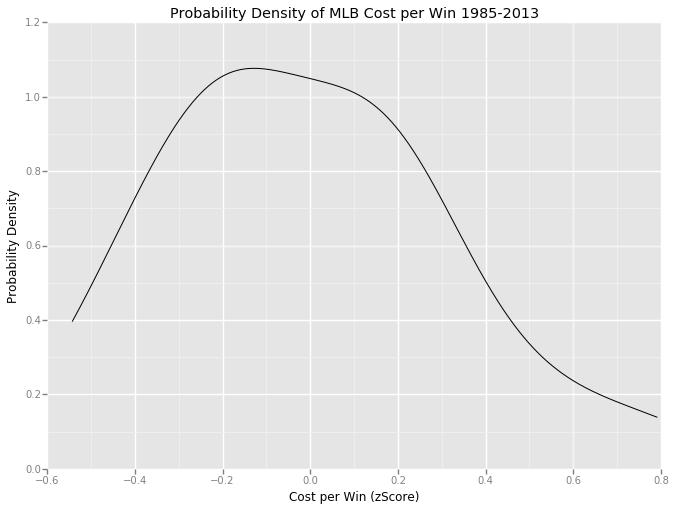

<ggplot: (40999137)>

In [181]:
%matplotlib inline
from ggplot import *

ggplot(aes(x = 'zcost_per_win'), data=efficiency) + \
    geom_density() + \
    xlab('Cost per Win (zScore)') + ylab('Probability Density') + ggtitle('Probability Density of MLB Cost per Win 1985-2013')

As expected, zCost per Win is approximately normally distributed. The mean value is slightly to the left of zero because more teams pay less than the average amount per win than pay above. This is mathematically possible because of a significant group of teams on the right tail of the distribution who pay significantly more than average per win and no corresponding group on the left tail who pay the same magnitude less per win. In particular, the extravagant spending of the New York Yankees makes everybody else look frugal in comparison.

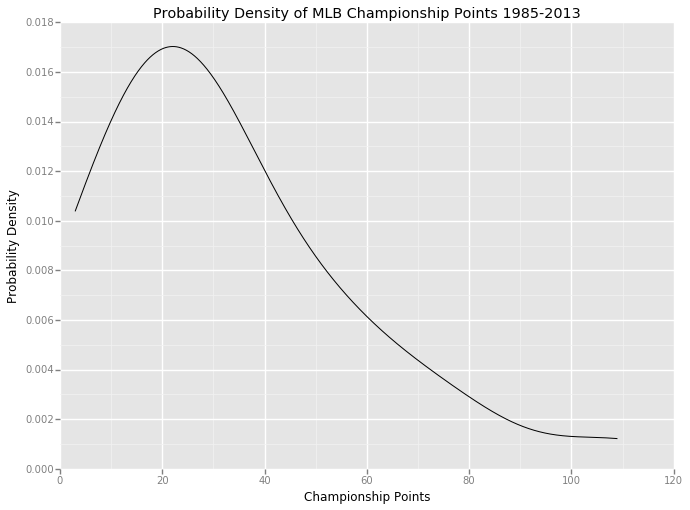

<ggplot: (40625051)>

In [182]:
%matplotlib inline
from ggplot import *

ggplot(aes(x = 'championship_points'), data=efficiency) + \
    geom_density() + \
    xlab('Championship Points') + ylab('Probability Density') + ggtitle('Probability Density of MLB Championship Points 1985-2013')

In [183]:
efficiency.skew()

championship_points    1.301614
mean_salary            1.389668
zcost_per_win          0.542763
dtype: float64

The distribution of Champioship Points shows a marked positive skew, with a value well over 1. This means that a majority of teams win relatively few Championship Points while a few remarkable franchises are extremely succesful (the Yankees have nearly 2.5 times as many Championship Points as the 75th percentile team!). This has been the actual experience in MLB, where the relative lack of constraints on spending has resulted in signficiantly less parity compared to the other major American sports leagues where spending is much more tightly regulated.

Having looked at the distrubtion of zCost per Win and Championship Points, I will now examine the relationship between these two variables.

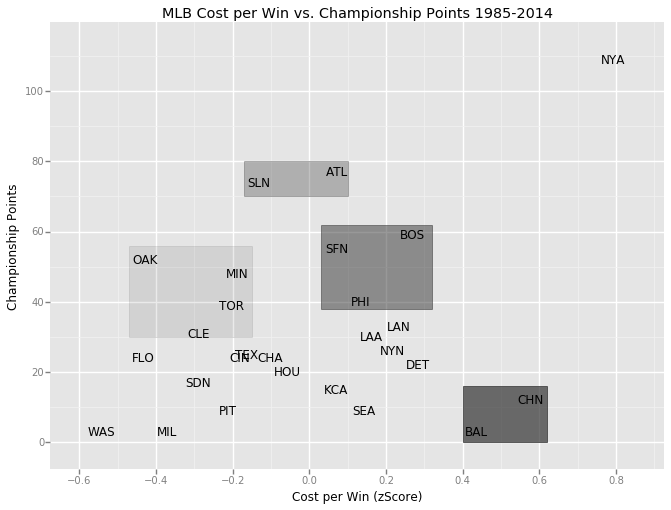

<ggplot: (12038432)>

In [184]:
%matplotlib inline
from ggplot import *

ggplot(aes(x = 'zcost_per_win', y = 'championship_points'), data=efficiency) + \
    geom_text(aes(label=efficiency.index)) + \
    geom_rect(xmin = -0.47, xmax = -0.15, ymin = 30, ymax = 56, alpha = 0.1) + \
    geom_rect(xmin = -0.17, xmax = 0.10, ymin = 70, ymax = 80, alpha = 0.3) + \
    geom_rect(xmin = 0.03, xmax = 0.32, ymin = 38, ymax = 62, alpha = 0.5) + \
    geom_rect(xmin = 0.4, xmax = 0.62, ymin = 0, ymax = 16, alpha = 0.7) + \
    xlab('Cost per Win (zScore)') + ylab('Championship Points') + ggtitle('MLB Cost per Win vs. Championship Points 1985-2014')

In the plot, above, each team's standardized cost per win (where a negative score means the team paid less than the mean per win) is plotted against it's accrued championship points. Four groups of teams, indicated by rectangles of increasing opacity stand out as particularly interesting:

1. **Small Market Heroes:** Oakland, Minnesotta, Toronto and Cleveland have done more with less, accruing 30+ championship points while paying significantly less than mean value per win. Oakland in particular has had spectacular success with limited resources.
2. **Model Franchises:** St. Louis and Atlanta win a lot (more than any team except the Yankees!) and do so while paying right around mean value per win. The success of these franchises can be attributed to excellent management.
3. **Big Market Powerhouses:** Boston, San Francisco, and Philadelphia spend significantly more than the mean value per win but have had significant success over the years. These franchises succesfully leverage their superior resources.
4. **Wasteful Spenders:** Baltimore and the Chicago Cubs spend well above the mean amount per win, yet have very little in terms of Championship points to show for it. These teams have been poorly managed and have had little success despite significant financial advantages.

The two outliers are worth mentioning as well. The most efficient team in the study are the Montreal Expos/Washington Nationals (WAS in the above plot). Starting in the 1980s, the Expos were famous for developing young talent, but due to financial constraints were not able to retain that talent through its prime years (under the current reserve clause players are subject to wage controls for the first six years of their MLB careers after which there are virtually no restrictions on their ability to switch teams and negotiate wages). All these talented young players caused them to massively overperform their miniscule payrolls, but they were never quite able to get over the hump and consistently had to watch Hall of Fame level players (e.g. Tim Raines, Andre Dawson, Gary Carter) leave for nothing in free agency. As the talent pipeline dried up in the late 90s, interest in the team plummeted and it wasn't long before they left for the much bigger market of Washington D.C.

On the opposite end of the spectrum, the New York Yankees (NYA) both paid the most per win and accrued the most championship points by massive amounts. The Yankees combination of market, history, international brand, and more recently broadcast network puts them in a different financial universe compared to the rest of baseball - an advantage that they have ruthelessly exploited for decades.

In [195]:
efficiency_r = round(efficiency['zcost_per_win'].corr(efficiency['championship_points']), 2)

print "Pearson's r for efficiency and Championship Points is {}.".format(efficiency_r)

Pearson's r for efficiency and Championship Points is 0.31.


The code above calculates Pearson's correlation coefficient for the standardized cost per win and the accrued championship points. Since a negative standardized cost per win represents a team that more efficiently buys wins, a positive correlation coefficient indicates that as efficiency decreases Championship Points increase! However, I suspect that this is due to the overwhelming success of the New York Yankees. Below I treat them and the Montreal Expos/Washington Nationals as outliers and remove them from the calculation:

In [196]:
from scipy.stats import pearsonr

efficiency_no_outliers = efficiency.drop(['NYA', 'WAS'])

efficiency_r = list(pearsonr(efficiency_no_outliers['zcost_per_win'], efficiency_no_outliers['championship_points']))

print "Pearson's r for efficiency and Championship Points is {}. The associated p-value of {} indicates that this is not a \
statistically significant result.".format((round(efficiency_r[0], 2)), (round(efficiency_r[1], 2)))

Pearson's r for efficiency and Championship Points is -0.08. The associated p-value of 0.7 indicates that this is not a statistically significant result.


**With the outliers removed, it becomes obvious that there is next to zero correlation (though now at least the correlation coefficient indicates the direction of the relationship that I would hope that it would, i.e. more efficient teams win more championships) between efficiently purchasing wins and winning championships in MLB.** Instead, it is likely that other factors such as overall payroll is more closely correlated with championship level success. 

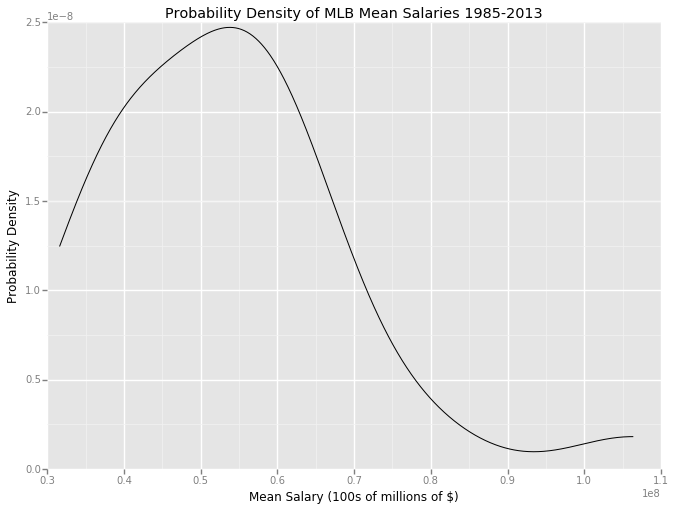

<ggplot: (41943517)>

In [192]:
%matplotlib inline
from ggplot import *

ggplot(aes(x = 'mean_salary'), data=efficiency) + \
    geom_density() + \
    xlab('Mean Salary (100s of millions of $)') + ylab('Probability Density') + \
    ggtitle('Probability Density of MLB Mean Salaries 1985-2013')

The above plot shows a significant positive skew (~1.3) to mean salary. This skew is primarily due to the massive financial dominance of the New York Yankees.

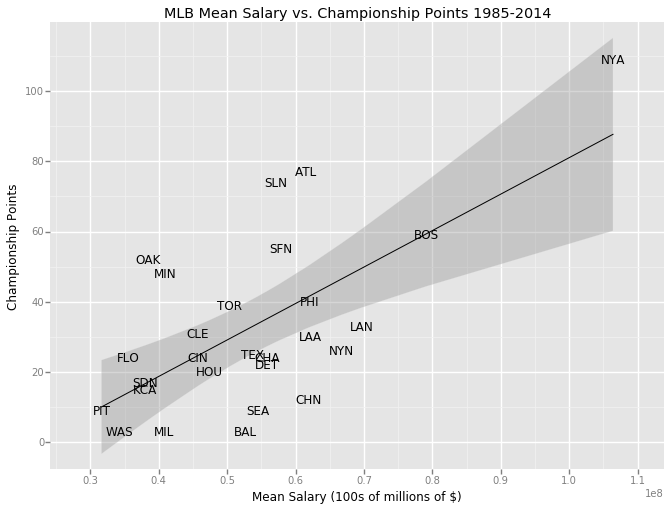

<ggplot: (40613471)>

In [193]:
%matplotlib inline
from ggplot import *

ggplot(aes(x = 'mean_salary', y = 'championship_points'), data=efficiency) + \
    geom_text(aes(label=efficiency.index)) + \
    stat_smooth(method = "lm") + \
    xlab('Mean Salary (100s of millions of $)') + ylab('Championship Points') + \
    ggtitle('MLB Mean Salary vs. Championship Points 1985-2014')

In [194]:
from scipy.stats import pearsonr

efficiency_salary_r = list(pearsonr(efficiency_salary['mean_salary'], efficiency_salary['championship_points']))

print "Pearson's r for mean salary and Championship Points is {}. The associated p-value of {} indicates that this is a \
statistically significant result.".format((round(efficiency_salary_r[0], 2)), (round(efficiency_salary_r[1], 3)))

Pearson's r for mean salary and Championship Points is 0.58. The associated p-value of 0.002 indicates that this is a statistically significant result.


Mean salary turn out to be a much strogner predictor of Championship Points then winning efficiently. It turns out that in MLB overwhelming resources swamp the effect of efficiently managing limited resources. The New York Yankees have been a dominant force with their massive payrolls for generations, and a majority of teams fall neatly within the 95% confidence interval of a simple linear model fit to the relationship. A robust R<sup>2</sup> of 0.58 and an associated p-value of 0.002 is indicative of a strong, statisically significant relationship between mean payroll and Championship Points.

Special praise should go to Oakland, Minnesota, San Francisco, St. Louis, and Atlanta, all of whom accrued handily more Championship Points than their payrolls would predict. These are the best run franchises over the past 3 decades.

The teams that most egregiously underperformed their payrolls are Baltimore, Seattle, and the Chicago Cubs. Baltimore at least has the excuse of being in the same division (and thus having to play more often) as the Yankees and the Red Sox the two highest payroll teams in the game. The Cubs and Mariners though would appear to be the most underperforming franchises of the past 3 decades.